In [ ]:
!pip install tensorflow
!pip install keras

In [ ]:
!unzip pickle.zip

Archive:  pickle.zip
replace pickle/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import tensorflow as tf
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.utils import to_categorical
import VariantCalling as vc
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
run_sequence = "CRT"
nb_epoch = 50
batch_size = 16
nb_filters = 48
nb_conv = 5
nb_pool = 3
nb_alignment = 2500
nb_channel = 1
nb_coverage = 100
nb_node = 128
train_loop = 1

# Sequence-specific Variables, too lazy to code the script everytime we train for a new sequence

In [ ]:
if run_sequence == "CRT":
    img_row, img_col = 101, 178
    clone_names = ["3D7","7G8","DD2"]
    nb_mutations = len(clone_names)
elif run_sequence == "DHPS":
    img_row, img_col = 101, 642
    clone_names = ["3D7","7G8","HB3"]
    nb_mutations = len(clone_names)
elif run_sequence == "DHFR":
    img_row, img_col = 101, 491
    clone_names = ["3D7","7G8","DD2","HB3"]
    nb_mutations = len(clone_names)

In [ ]:
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_mse', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_weights= self.model.get_weights()

In [ ]:
"""
This section to test ratio_gen, which is wrapper for alignments
"""
dg = vc.VariantCallingData(file_name="clones.txt",gen_mode=2,pkl_sequence=run_sequence,pkl_clones=clone_names)
alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
prob_lists = (np.array(prob_lists)*100).tolist()


Done, Number of alignments: 2500


# Base model without augmentation

In [ ]:
alignments = dg.char_to_int(alignments_raw).reshape(nb_alignment,1,img_row,img_col)

[37.0, 40.0, 23.0]


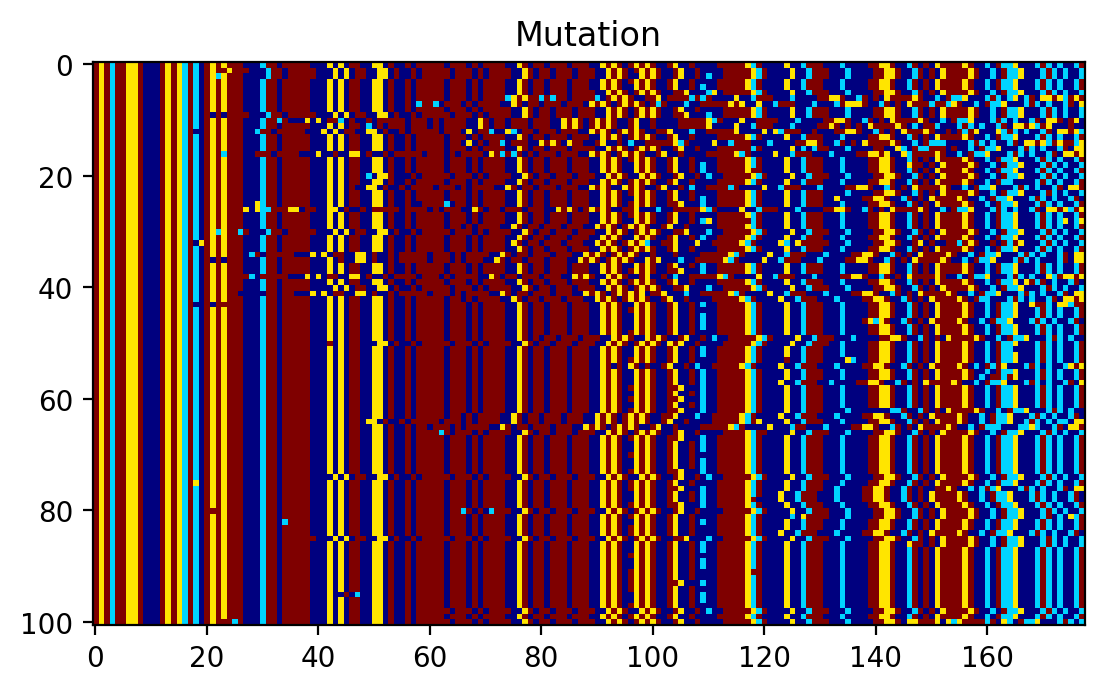

In [ ]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignments[0][0],cmap='jet')
print(prob_lists[0])

In [ ]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
print(train_alignments.shape)
print(train_prob_lists.shape)

(2000, 1, 101, 178)
(2000, 3)


In [ ]:
print(train_alignments.shape)
print(valid_alignments.shape)


train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


(2000, 1, 101, 178)
(500, 1, 101, 178)


In [ ]:
model = Sequential()
model.add(Conv2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Flatten())
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
#model.add(Dense(nb_node))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
model.add(Dense(nb_mutations))
model.add(Activation('softmax'))
model.add(Lambda(lambda x: x * 100))
model.compile(metrics=['mse'],loss='categorical_crossentropy',optimizer='adam')

In [ ]:
save_best_model = SaveBestModel()
trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
model.set_weights(save_best_model.best_weights)

Epoch 1/50
125/125 [==============================] - 16s 12ms/step - loss: 109.8716 - mse: 323.8319 - val_loss: 109.8658 - val_mse: 305.2462
Epoch 2/50
125/125 [==============================] - 1s 7ms/step - loss: 106.4159 - mse: 249.0902 - val_loss: 104.4487 - val_mse: 188.8466
Epoch 3/50
125/125 [==============================] - 1s 7ms/step - loss: 103.5807 - mse: 190.1205 - val_loss: 103.9565 - val_mse: 181.4926
Epoch 4/50
125/125 [==============================] - 1s 7ms/step - loss: 103.3788 - mse: 186.4624 - val_loss: 103.7426 - val_mse: 175.4487
Epoch 5/50
125/125 [==============================] - 1s 7ms/step - loss: 103.0444 - mse: 179.5267 - val_loss: 103.5996 - val_mse: 173.0523
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 103.0208 - mse: 179.4677 - val_loss: 103.7053 - val_mse: 176.2738
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 102.9155 - mse: 175.9393 - val_loss: 103.7730 - val_mse: 175.3164
Epoch 8/50
125/125

In [ ]:
for _ in range(0,train_loop):
    """
    This section to test ratio_gen, which is wrapper for alignments
    """
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
    prob_lists = (np.array(prob_lists)*100).tolist()
    alignments = dg.char_to_int(alignments_raw).reshape(nb_alignment,1,img_row,img_col)
    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])
    rng.shuffle(idxs)
    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
    #train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
    print(train_alignments.shape)
    print(train_prob_lists.shape)
    print(train_alignments.shape)
    print(valid_alignments.shape)
    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)
    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')
    train_alignments /= 3
    valid_alignments /= 3
    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
    model.set_weights(save_best_model.best_weights)

Done, Number of alignments: 2500
(2000, 1, 101, 178)
(2000, 3)
(2000, 1, 101, 178)
(500, 1, 101, 178)
Epoch 1/50
125/125 [==============================] - 1s 10ms/step - loss: 96.4704 - mse: 46.3092 - val_loss: 94.8087 - val_mse: 31.9663
Epoch 2/50
125/125 [==============================] - 1s 8ms/step - loss: 96.0607 - mse: 40.3479 - val_loss: 94.4079 - val_mse: 25.8243
Epoch 3/50
125/125 [==============================] - 1s 6ms/step - loss: 95.7062 - mse: 33.3301 - val_loss: 94.9187 - val_mse: 37.5329
Epoch 4/50
125/125 [==============================] - 1s 7ms/step - loss: 95.6862 - mse: 33.5472 - val_loss: 94.8162 - val_mse: 32.1674
Epoch 5/50
125/125 [==============================] - 1s 7ms/step - loss: 95.4930 - mse: 30.2887 - val_loss: 94.6883 - val_mse: 32.8712
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 95.3674 - mse: 28.3016 - val_loss: 94.3220 - val_mse: 25.8764
Epoch 7/50
125/125 [==============================] - 1s 11ms/step - loss: 95.312

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 35, 48)        1248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 11, 48)         0         
 D)                                                              
                                                                 
 activation (Activation)     (None, 6, 11, 48)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 3, 48)          57648     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 48)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 1, 1, 48)          0

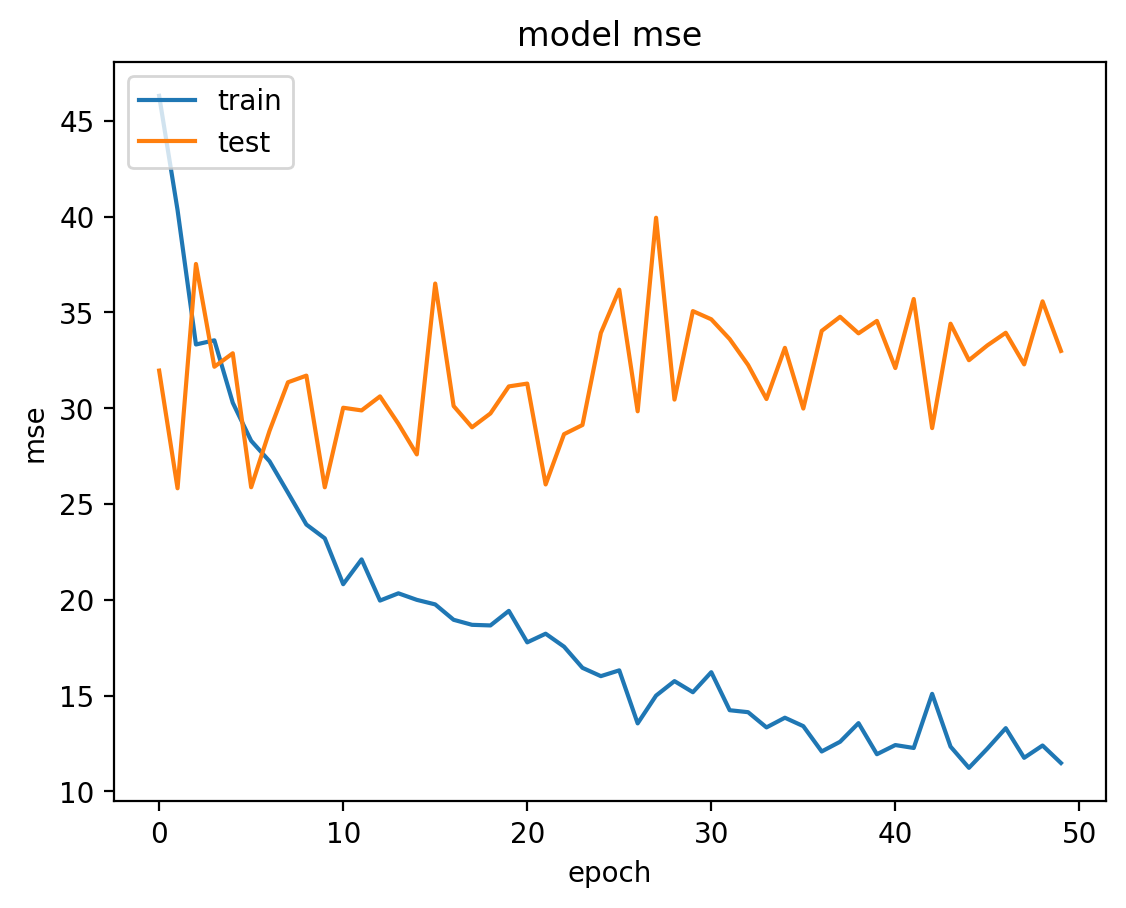

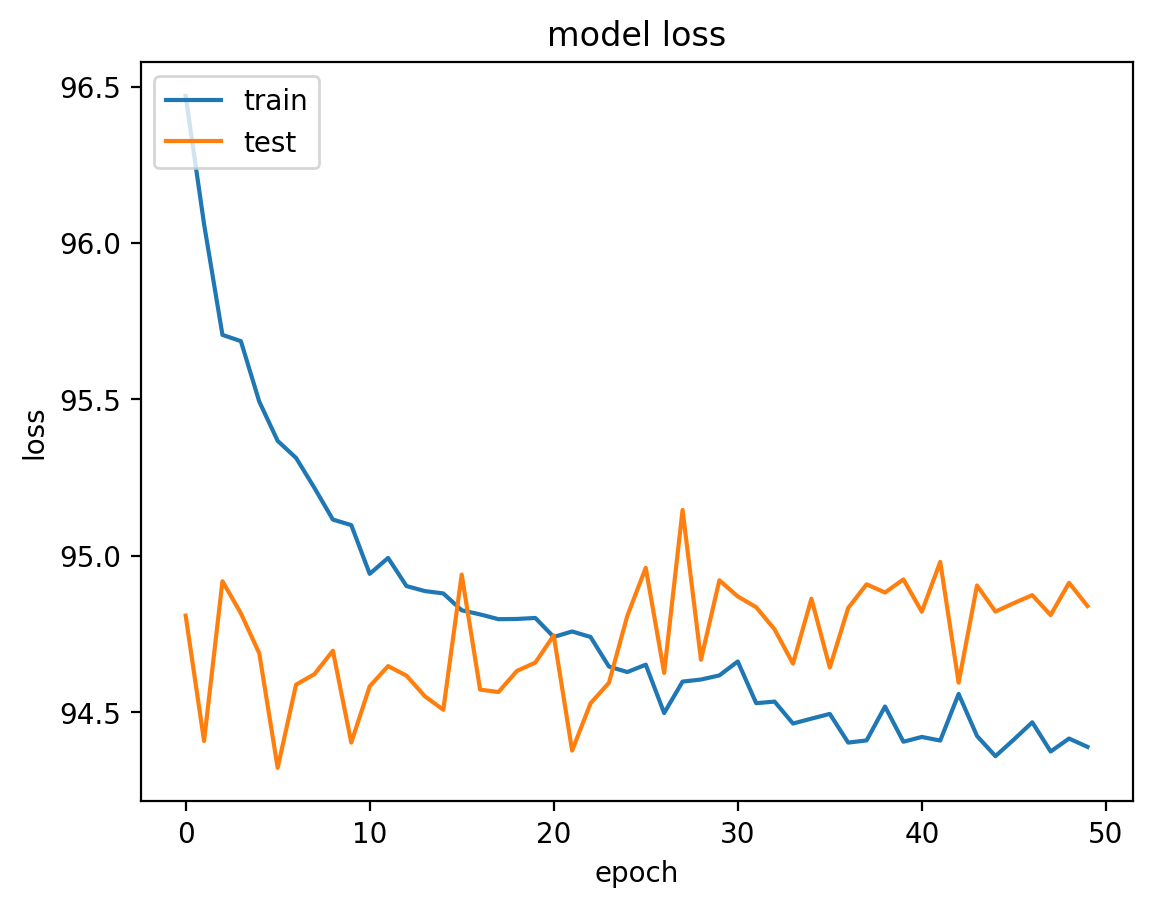

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.summary()
print(trained_model.history.keys())
# summarize history for accuracy
plt.plot(trained_model.history['mse'])
plt.plot(trained_model.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save('ref.h5')

In [ ]:
with open('output.csv', 'w') as file:
    predict_array = model.predict(valid_alignments).tolist()
    for i in range(0, len(valid_prob_lists)):
        file.write("\nPredicted\n")
        file.write(str(predict_array[i]))
        file.write("\nActual\n")
        file.write(str(valid_prob_lists[i]))

16/16 [==============================] - 0s 9ms/step


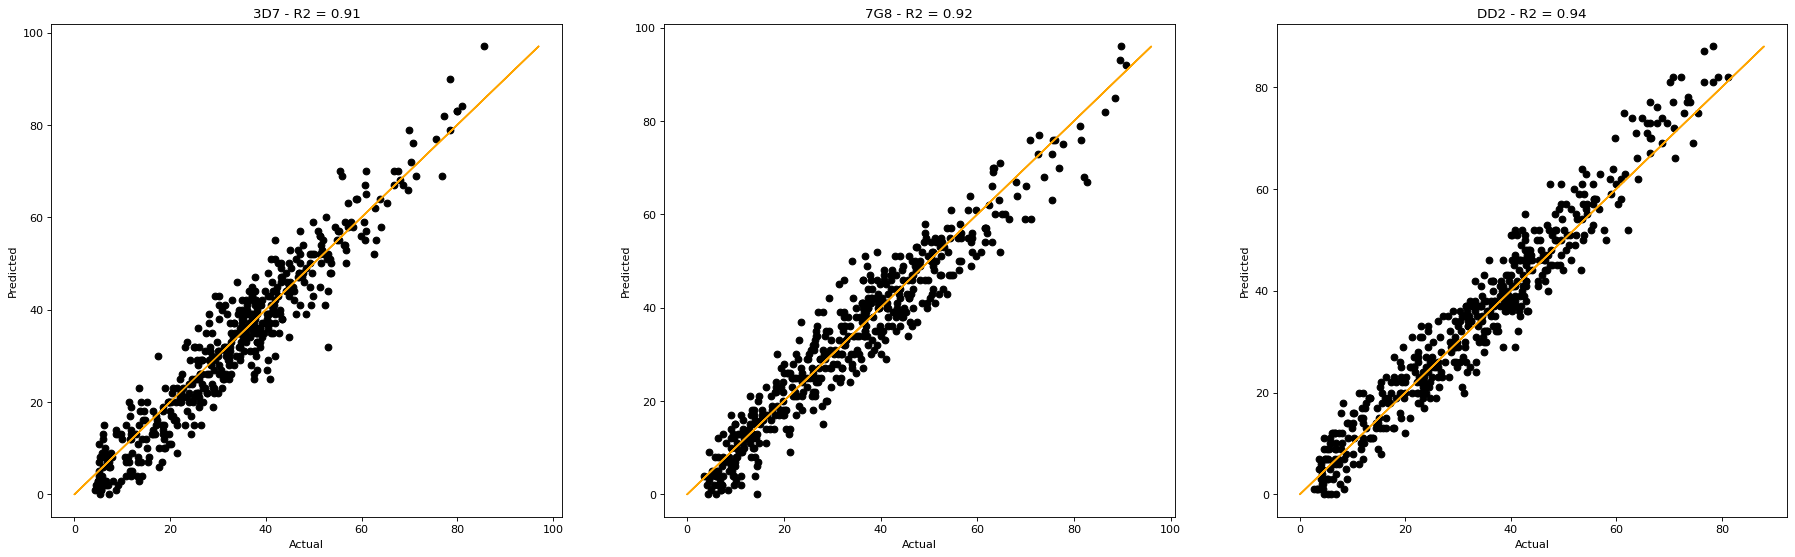

In [ ]:
# Data visualisation and performance evaluation
import pandas as pd
from scipy.stats import linregress
from sklearn.metrics import r2_score

df_predict_base = pd.DataFrame(predict_array)
df_actual_base = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict_base.columns = clone_names
df_actual_base.columns = clone_names

plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2_base = r2_score(df_actual_base[clone_names[i]], df_predict_base[clone_names[i]])
    (m_1, b_1) = np.polyfit(df_actual_base[clone_names[i]], df_predict_base[clone_names[i]], 1)
    yp_1 = np.polyval([1, 0], df_actual_base[clone_names[i]])
    plt.plot(df_actual_base[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name} - R2 = {r2_score}'.format(seq_name=clone_names[i],r2_score=round(r2_base,2)))
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.scatter(df_predict_base[clone_names[i]], df_actual_base[clone_names[i]],color='black')

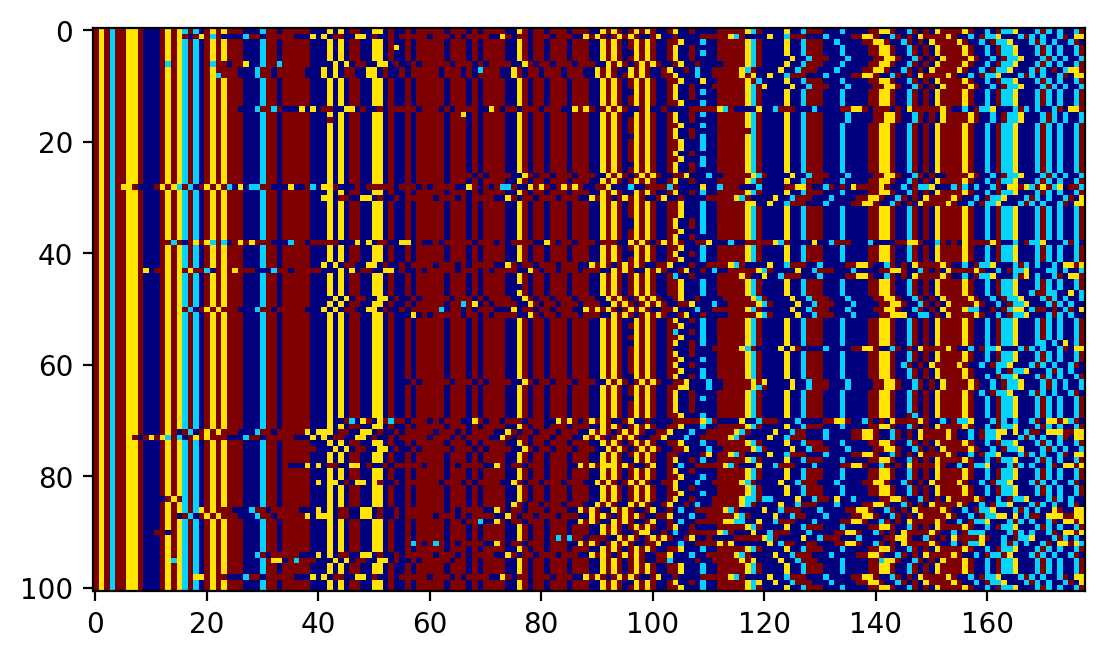

In [ ]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.imshow(valid_alignments[0].reshape(nb_channel,img_row,img_col)[0],cmap='jet')

# Reference Channel

In [ ]:
nb_channel = 2
alignments = [dg._array_dup(i,101) for i in alignments_raw]
alignments = dg.char_to_int(alignments)

# Here we display an image and check the error rate

In [ ]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignments[0][0],cmap='jet')
print(prob_lists[0])

In [ ]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
print(train_alignments.shape)
print(train_prob_lists.shape)

In [ ]:
print(train_alignments.shape)
print(valid_alignments.shape)


train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


In [ ]:
model = Sequential()
model.add(Conv2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Flatten())
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
#model.add(Dense(nb_node))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
model.add(Dense(nb_mutations))
model.add(Activation('softmax'))
model.add(Lambda(lambda x: x * 100))
model.compile(metrics=['mse'],loss='categorical_crossentropy',optimizer='adam')

In [ ]:
save_best_model = SaveBestModel()
trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
model.set_weights(save_best_model.best_weights)

Epoch 1/50
125/125 [==============================] - 4s 12ms/step - loss: 109.8935 - mse: 325.7813 - val_loss: 109.8596 - val_mse: 346.3527
Epoch 2/50
125/125 [==============================] - 1s 7ms/step - loss: 109.7963 - mse: 323.6458 - val_loss: 108.0573 - val_mse: 308.3406
Epoch 3/50
125/125 [==============================] - 1s 7ms/step - loss: 104.3237 - mse: 209.9634 - val_loss: 101.8420 - val_mse: 177.2333
Epoch 4/50
125/125 [==============================] - 1s 7ms/step - loss: 102.9758 - mse: 182.8084 - val_loss: 101.6568 - val_mse: 173.7696
Epoch 5/50
125/125 [==============================] - 1s 7ms/step - loss: 102.7271 - mse: 177.6617 - val_loss: 101.6238 - val_mse: 171.9013
Epoch 6/50
125/125 [==============================] - 1s 7ms/step - loss: 102.6498 - mse: 175.4207 - val_loss: 101.5881 - val_mse: 172.7995
Epoch 7/50
125/125 [==============================] - 1s 7ms/step - loss: 101.9055 - mse: 158.7591 - val_loss: 97.4033 - val_mse: 83.0207
Epoch 8/50
125/125 [=

Here we run train loop to mitigate memory crunch

In [ ]:
for _ in range(0,train_loop):
    """
    This section to test ratio_gen, which is wrapper for alignments
    """
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
    prob_lists = (np.array(prob_lists)*100).tolist()
    alignments = [dg._array_dup(i,101) for i in alignments_raw]
    alignments = dg.char_to_int(alignments)
    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])
    rng.shuffle(idxs)
    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
    #train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
    print(train_alignments.shape)
    print(train_prob_lists.shape)
    print(train_alignments.shape)
    print(valid_alignments.shape)
    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)
    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')
    train_alignments /= 3
    valid_alignments /= 3
    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
    model.set_weights(save_best_model.best_weights)

Done, Number of alignments: 2500
(2000, 2, 101, 178)
(2000, 3)
(2000, 2, 101, 178)
(500, 2, 101, 178)
Epoch 1/50
125/125 [==============================] - 1s 10ms/step - loss: 95.9474 - mse: 41.8227 - val_loss: 94.1952 - val_mse: 31.3008
Epoch 2/50
125/125 [==============================] - 1s 9ms/step - loss: 95.4775 - mse: 33.7691 - val_loss: 93.9596 - val_mse: 27.9188
Epoch 3/50
125/125 [==============================] - 1s 7ms/step - loss: 95.2796 - mse: 30.9331 - val_loss: 93.8819 - val_mse: 26.6317
Epoch 4/50
125/125 [==============================] - 1s 7ms/step - loss: 95.1304 - mse: 28.5132 - val_loss: 93.8882 - val_mse: 25.5517
Epoch 5/50
125/125 [==============================] - 1s 7ms/step - loss: 95.0221 - mse: 26.7411 - val_loss: 93.9846 - val_mse: 29.1741
Epoch 6/50
125/125 [==============================] - 1s 7ms/step - loss: 94.8617 - mse: 23.7424 - val_loss: 93.8625 - val_mse: 25.8593
Epoch 7/50
125/125 [==============================] - 1s 7ms/step - loss: 94.7953

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 20, 35, 48)        2448      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 11, 48)         0         
 g2D)                                                            
                                                                 
 activation_6 (Activation)   (None, 6, 11, 48)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 3, 48)          57648     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 1, 1, 48)          0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 48)         

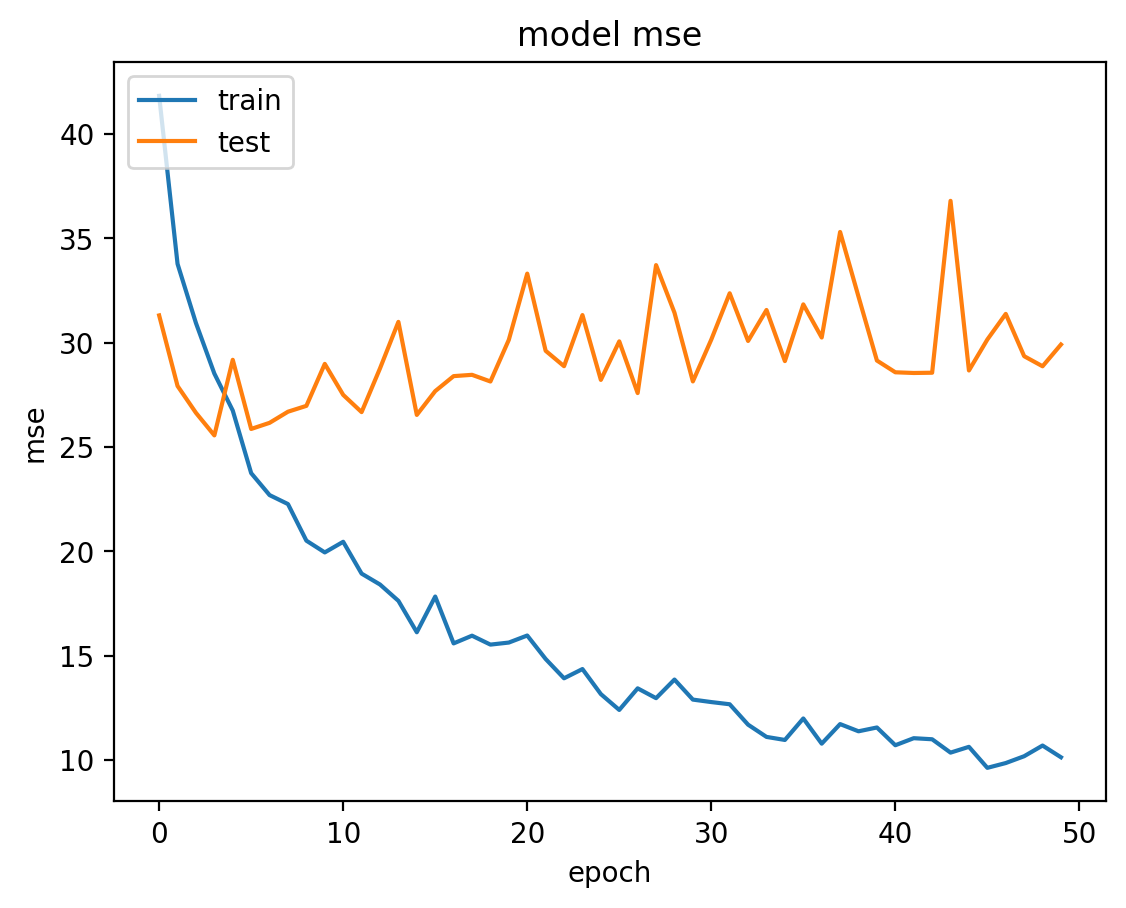

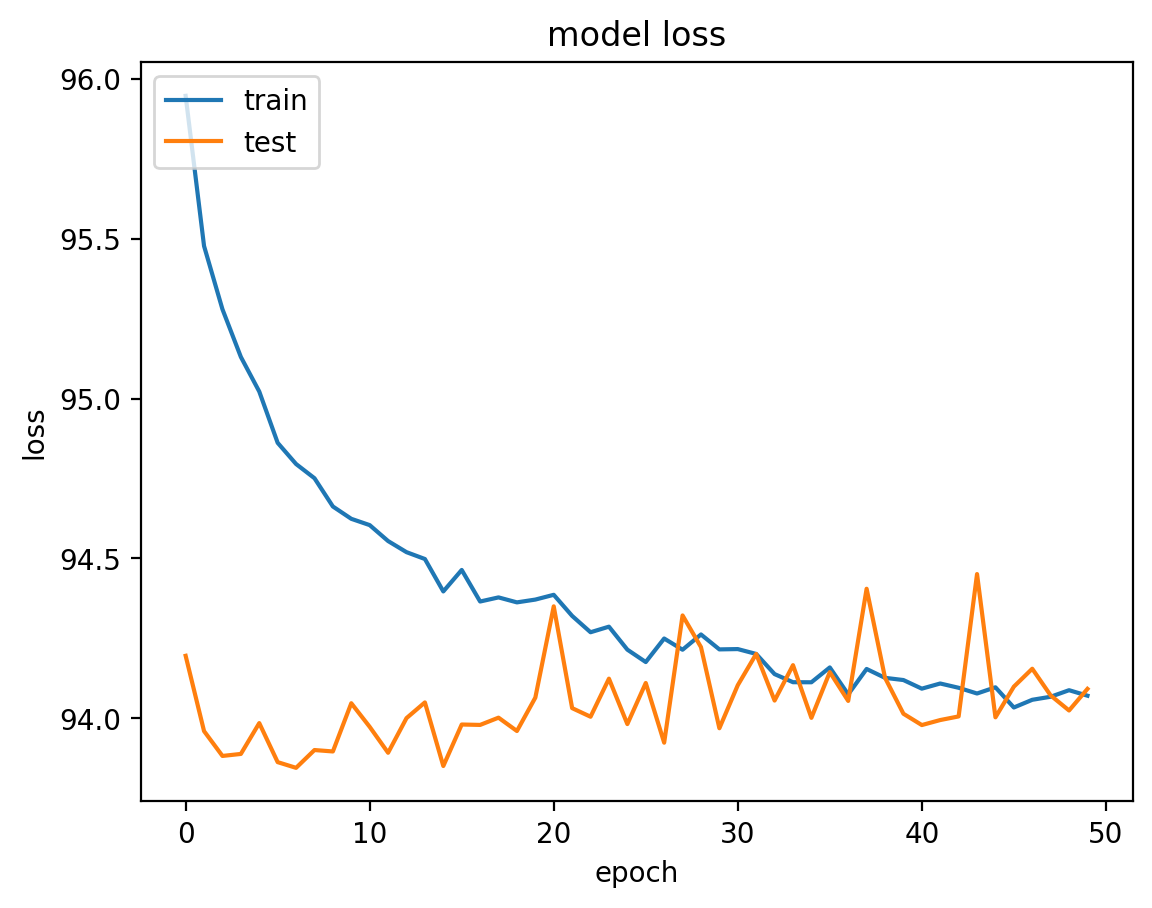

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.summary()
print(trained_model.history.keys())
# summarize history for accuracy
plt.plot(trained_model.history['mse'])
plt.plot(trained_model.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save('ref.h5')

In [ ]:
with open('output.csv', 'w') as file:
    predict_array = model.predict(valid_alignments).tolist()
    for i in range(0, len(valid_prob_lists)):
        file.write("\nPredicted\n")
        file.write(str(predict_array[i]))
        file.write("\nActual\n")
        file.write(str(valid_prob_lists[i]))

16/16 [==============================] - 0s 9ms/step


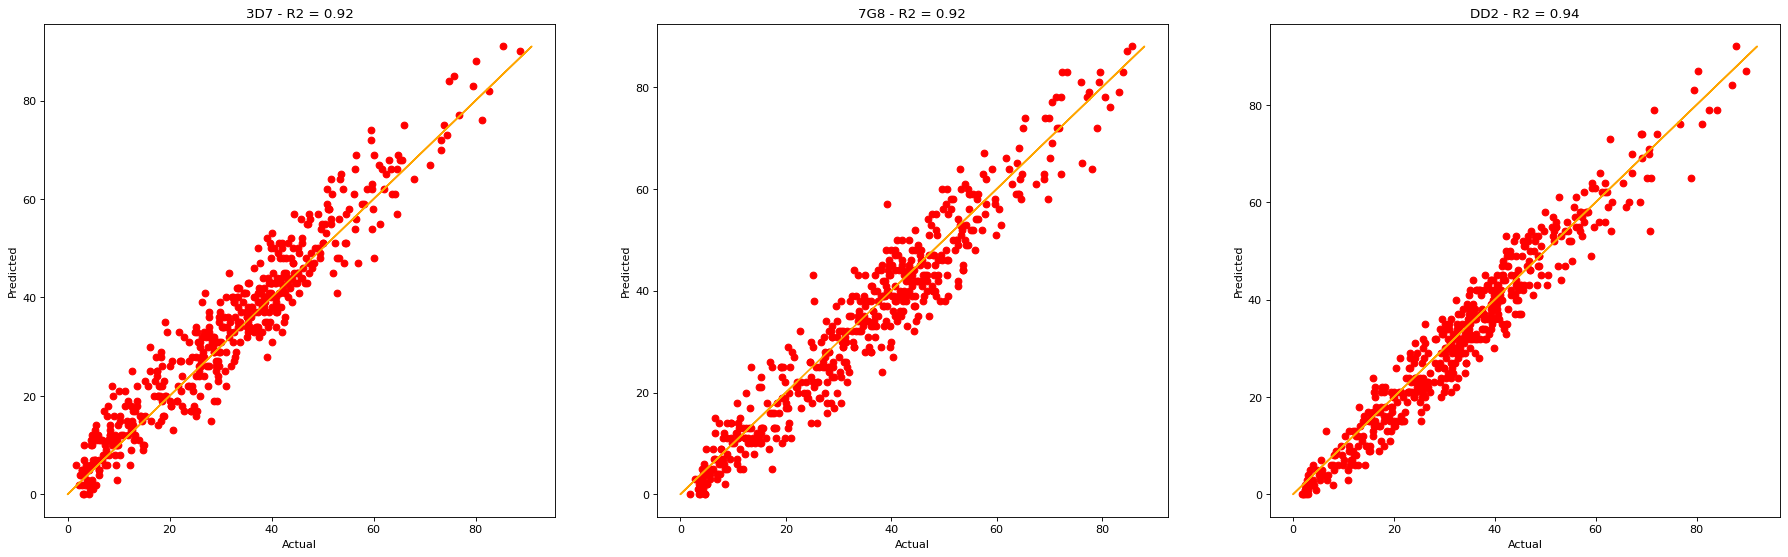

In [ ]:
# Data visualisation and performance evaluation
import pandas as pd
from scipy.stats import linregress
from sklearn.metrics import r2_score

df_predict = pd.DataFrame(predict_array)
df_actual = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict.columns = clone_names
df_actual.columns = clone_names

plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2 = r2_score(df_actual[clone_names[i]], df_predict[clone_names[i]])
    (m_1, b_1) = np.polyfit(df_actual[clone_names[i]], df_predict[clone_names[i]], 1)
    yp_1 = np.polyval([1, 0], df_actual[clone_names[i]])
    plt.plot(df_actual[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name} - R2 = {r2_score}'.format(seq_name=clone_names[i],r2_score=round(r2,2)))
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.scatter(df_predict[clone_names[i]], df_actual[clone_names[i]],color='red')

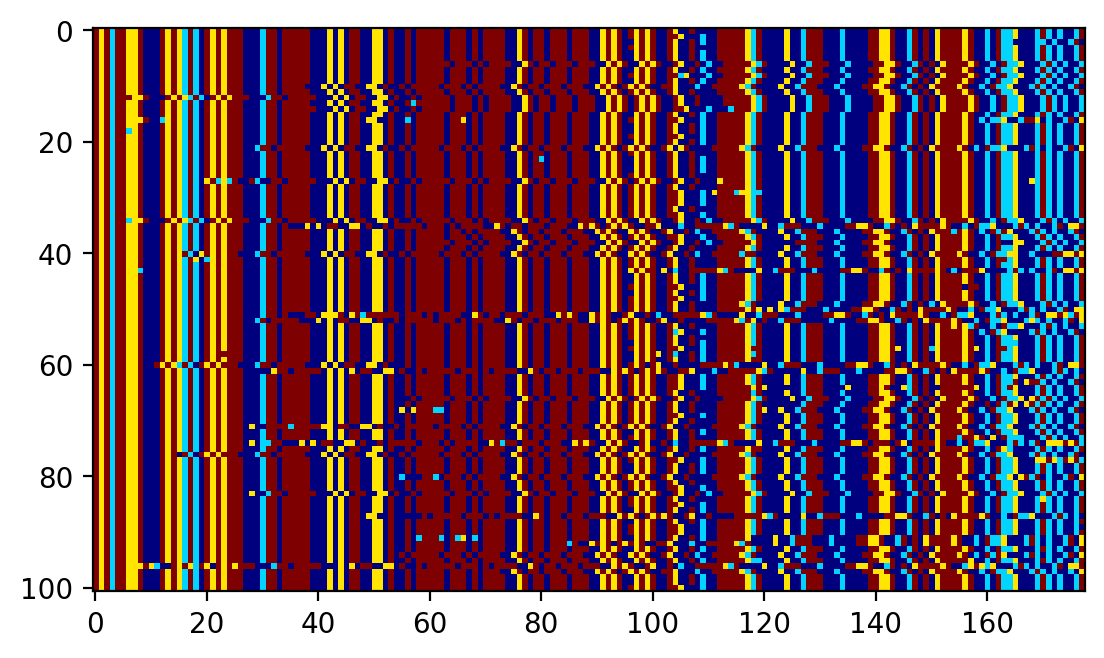

In [ ]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.imshow(valid_alignments[0].reshape(nb_channel,img_row,img_col)[0],cmap='jet')

# Here we run the same training regime but replacing the second channel with a binary map

In [ ]:
alignments = [dg._array_binary_mask(i,101) for i in alignments_raw]
alignments = dg.char_to_int(alignments)

# Display the binary map

[25.0, 63.0, 12.0]


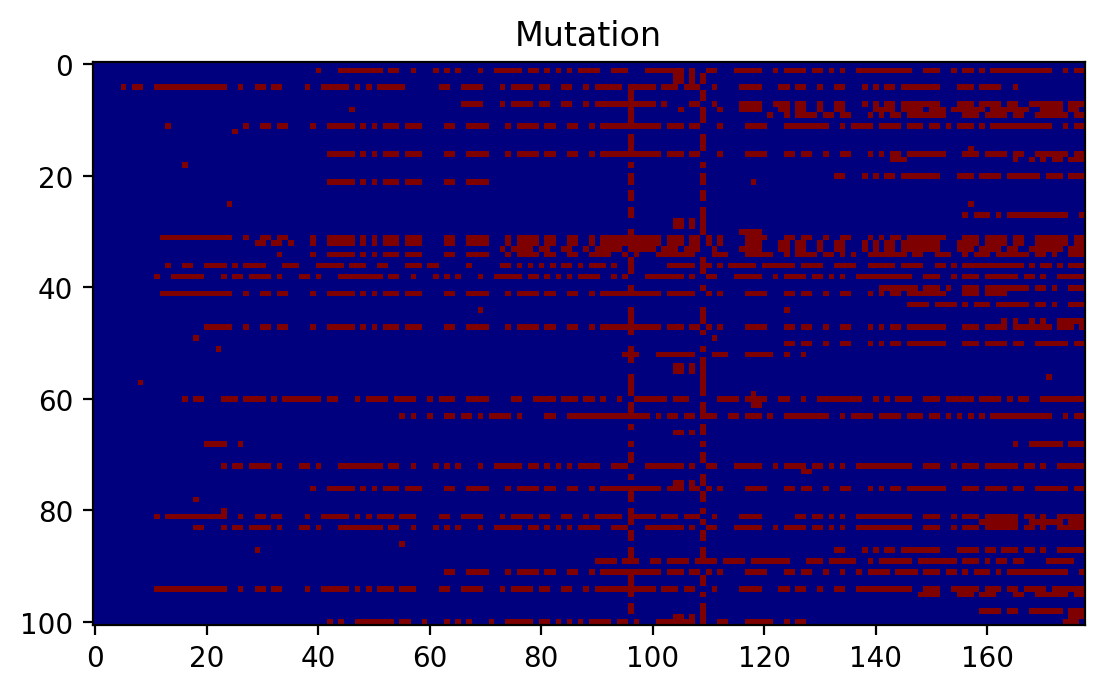

In [ ]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignments[0][1],cmap='jet')
print(prob_lists[0])

In [ ]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
print(train_alignments.shape)
print(train_prob_lists.shape)

(2000, 2, 101, 178)
(2000, 3)


In [ ]:
print(train_alignments.shape)
print(valid_alignments.shape)


train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


(2000, 2, 101, 178)
(500, 2, 101, 178)


In [ ]:
model = Sequential()
model.add(Conv2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Flatten())
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
#model.add(Dense(24))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
model.add(Dense(nb_mutations))
model.add(Activation('softmax'))
model.add(Lambda(lambda x: x * 100))
model.compile(metrics=['mse'],loss='categorical_crossentropy',optimizer='adam')

In [ ]:
save_best_model = SaveBestModel()
trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
model.set_weights(save_best_model.best_weights)

Epoch 1/50
125/125 [==============================] - 4s 11ms/step - loss: 109.7537 - mse: 326.7068 - val_loss: 105.6446 - val_mse: 261.7366
Epoch 2/50
125/125 [==============================] - 1s 8ms/step - loss: 103.7685 - mse: 201.8554 - val_loss: 102.2645 - val_mse: 197.7485
Epoch 3/50
125/125 [==============================] - 1s 7ms/step - loss: 102.6108 - mse: 179.9866 - val_loss: 102.1832 - val_mse: 195.9051
Epoch 4/50
125/125 [==============================] - 1s 7ms/step - loss: 102.3681 - mse: 174.8563 - val_loss: 102.0583 - val_mse: 193.8567
Epoch 5/50
125/125 [==============================] - 1s 7ms/step - loss: 102.2880 - mse: 172.5703 - val_loss: 101.9154 - val_mse: 190.4962
Epoch 6/50
125/125 [==============================] - 1s 7ms/step - loss: 101.3006 - mse: 149.7023 - val_loss: 97.6161 - val_mse: 91.5574
Epoch 7/50
125/125 [==============================] - 1s 7ms/step - loss: 97.6929 - mse: 73.7737 - val_loss: 95.1057 - val_mse: 46.1789
Epoch 8/50
125/125 [=====

Here we run train loop to mitigate memory crunch

In [ ]:
for _ in range(0,train_loop):
    """
    This section to test ratio_gen, which is wrapper for alignments
    """
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
    prob_lists = (np.array(prob_lists)*100).tolist()
    alignments = [dg._array_binary_mask(i,101) for i in alignments_raw]
    alignments = dg.char_to_int(alignments)
    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])
    rng.shuffle(idxs)
    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
    #train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
    print(train_alignments.shape)
    print(train_prob_lists.shape)
    print(train_alignments.shape)
    print(valid_alignments.shape)
    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)
    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')
    train_alignments /= 3
    valid_alignments /= 3
    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
    model.set_weights(save_best_model.best_weights)

Done, Number of alignments: 2500
(2000, 2, 101, 178)
(2000, 3)
(2000, 2, 101, 178)
(500, 2, 101, 178)
Epoch 1/50
125/125 [==============================] - 1s 9ms/step - loss: 96.4943 - mse: 38.1443 - val_loss: 96.2076 - val_mse: 27.9982
Epoch 2/50
125/125 [==============================] - 1s 7ms/step - loss: 95.9727 - mse: 29.7426 - val_loss: 96.0337 - val_mse: 23.7327
Epoch 3/50
125/125 [==============================] - 1s 7ms/step - loss: 95.7533 - mse: 25.4207 - val_loss: 95.9316 - val_mse: 23.0300
Epoch 4/50
125/125 [==============================] - 1s 8ms/step - loss: 95.5660 - mse: 22.4278 - val_loss: 96.2089 - val_mse: 27.8974
Epoch 5/50
125/125 [==============================] - 1s 10ms/step - loss: 95.4540 - mse: 20.9591 - val_loss: 96.0461 - val_mse: 24.9727
Epoch 6/50
125/125 [==============================] - 1s 7ms/step - loss: 95.3333 - mse: 18.8883 - val_loss: 96.1137 - val_mse: 26.2111
Epoch 7/50
125/125 [==============================] - 1s 7ms/step - loss: 95.2630

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 20, 35, 48)        2448      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 6, 11, 48)         0         
 g2D)                                                            
                                                                 
 activation_12 (Activation)  (None, 6, 11, 48)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 2, 3, 48)          57648     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 1, 1, 48)          0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 1, 1, 48)         

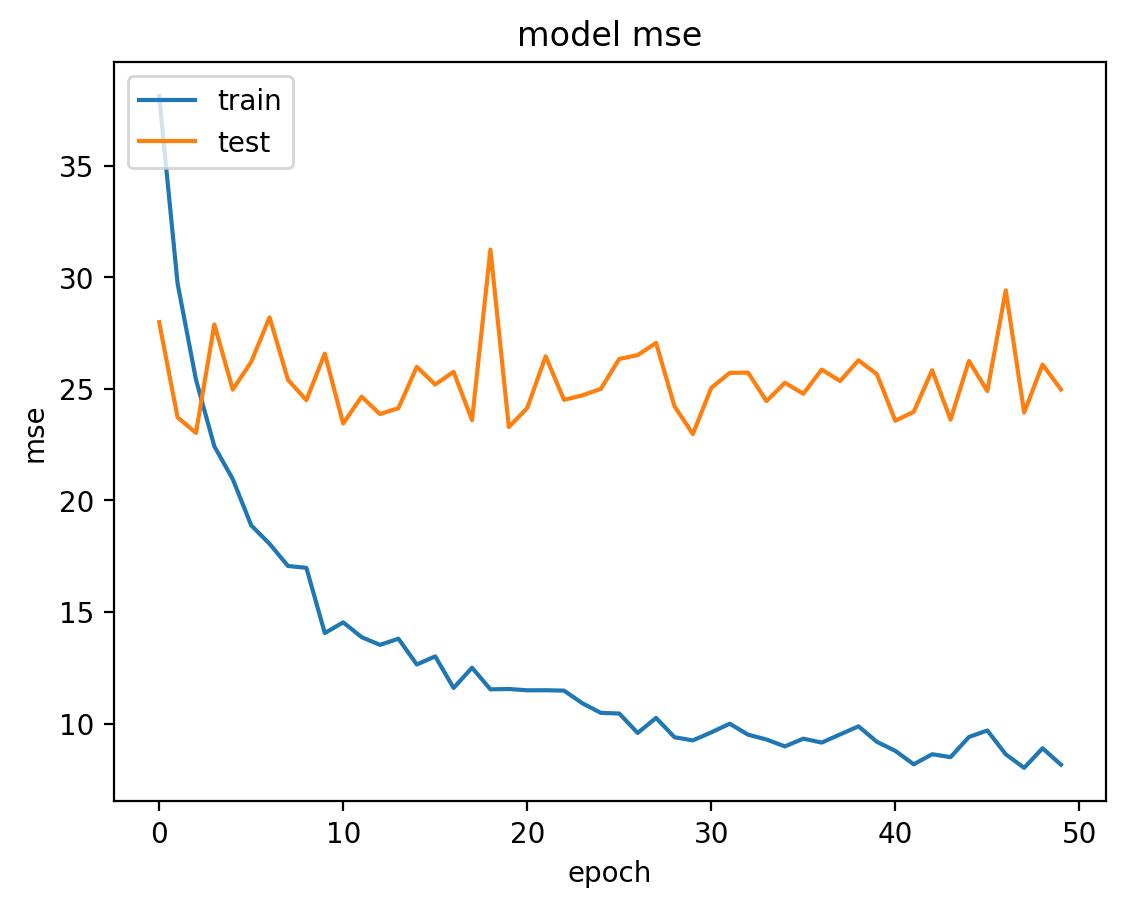

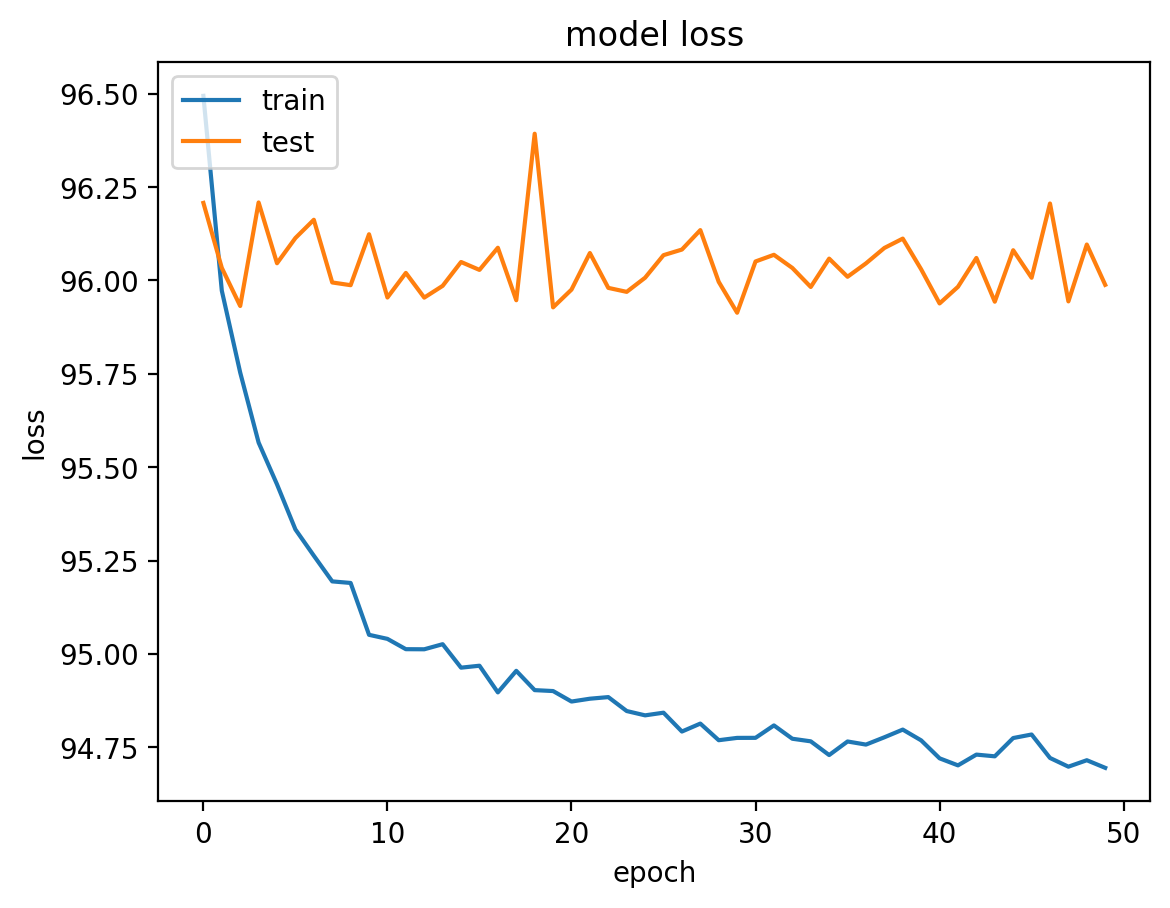

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.summary()
print(trained_model.history.keys())
# summarize history for accuracy
plt.plot(trained_model.history['mse'])
plt.plot(trained_model.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save('bin_map.h5')

In [ ]:
with open('output.csv', 'w') as file:
    predict_array = model.predict(valid_alignments).tolist()
    for i in range(0, len(valid_prob_lists)):
        file.write("\nPredicted\n")
        file.write(str(predict_array[i]))
        file.write("\nActual\n")
        file.write(str(valid_prob_lists[i]))

16/16 [==============================] - 0s 6ms/step


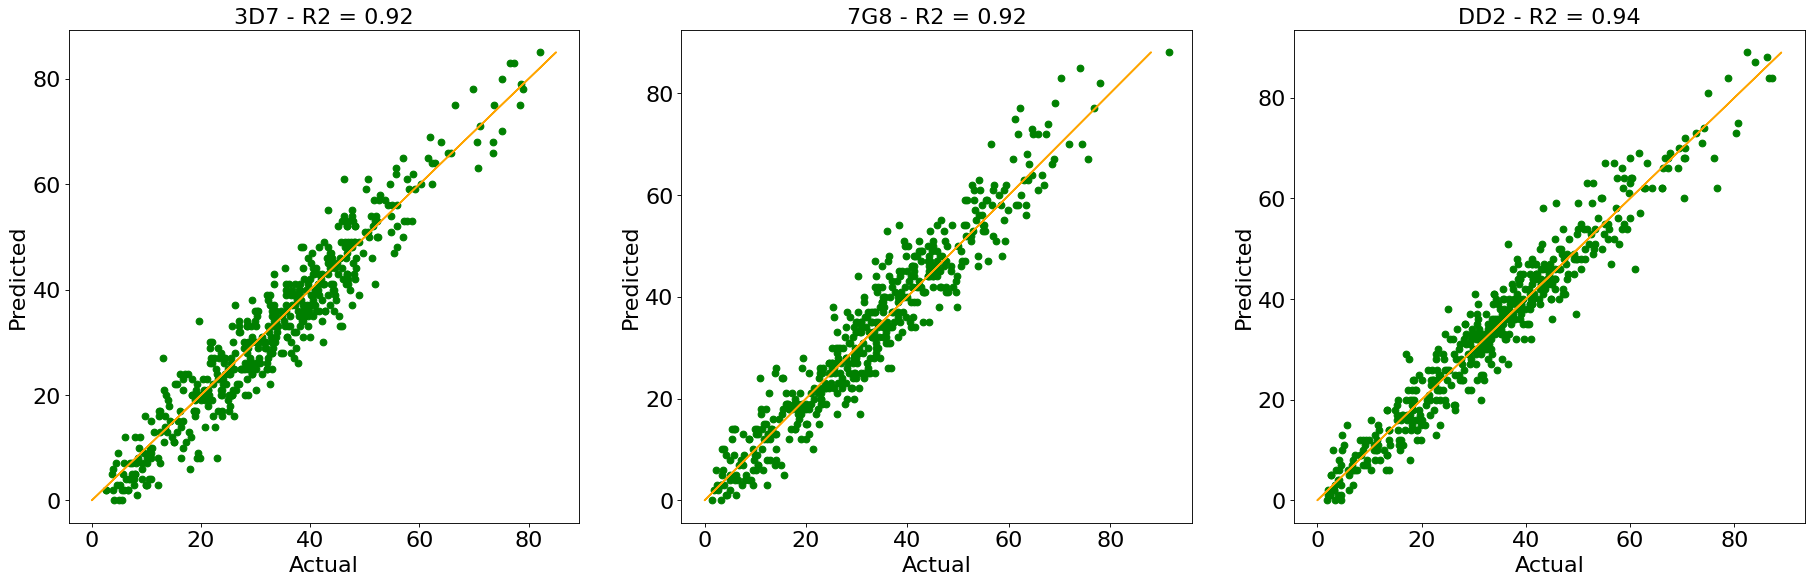

In [ ]:
# Data visualisation and performance evaluation
import pandas as pd
from scipy.stats import linregress
from sklearn.metrics import r2_score

df_predict_binary_map = pd.DataFrame(predict_array)
df_actual_binary_map = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict_binary_map.columns = clone_names
df_actual_binary_map.columns = clone_names

plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2 = r2_score(df_actual_binary_map[clone_names[i]], df_predict_binary_map[clone_names[i]])
    (m_1, b_1) = np.polyfit(df_actual_binary_map[clone_names[i]], df_predict_binary_map[clone_names[i]], 1)
    yp_1 = np.polyval([1, 0], df_actual_binary_map[clone_names[i]])
    plt.plot(df_actual_binary_map[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name} - R2 = {r2_score}'.format(seq_name=clone_names[i],r2_score=round(r2,2)),fontsize=20)
    plt.ylabel('Predicted',fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Actual',fontsize=20)
    plt.xticks(fontsize=20)
    plt.scatter(df_predict_binary_map[clone_names[i]], df_actual_binary_map[clone_names[i]],color='green')

# Here we run with both binary map and referecen matrix

In [ ]:
alignments = [dg._array_binary_mask(i,101,True) for i in alignments_raw]
alignments = dg.char_to_int(alignments)

# Here the number of channel will be updated to 3
nb_channel = 3

[28.000000000000004, 28.000000000000004, 44.0]


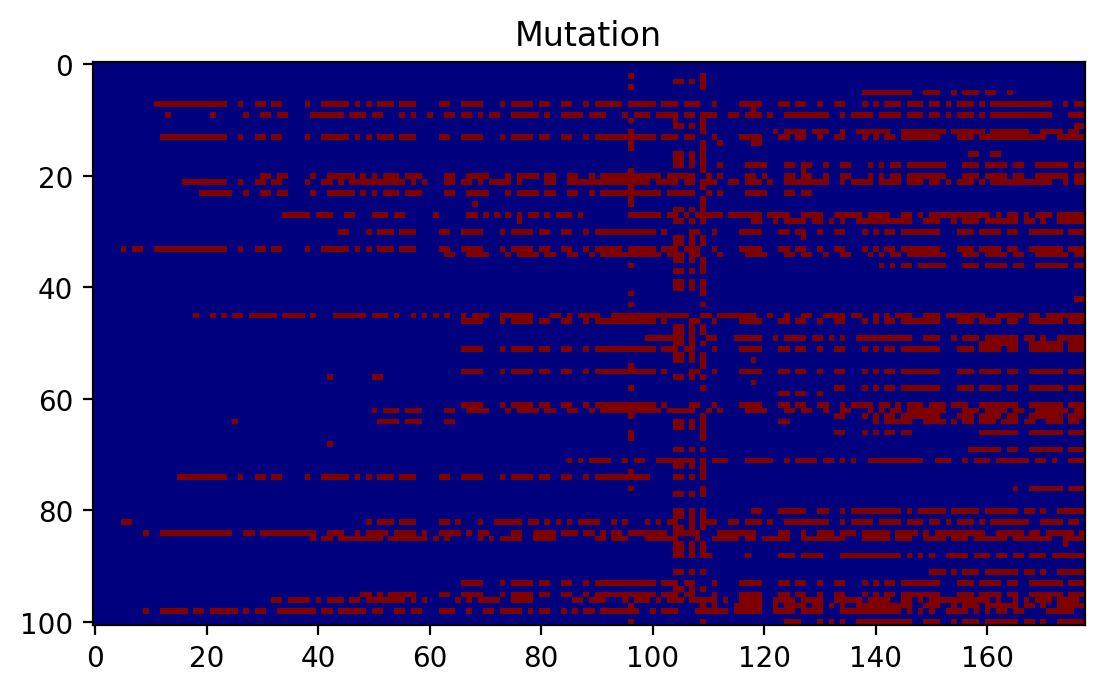

In [ ]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignments[0][1],cmap='jet')
print(prob_lists[0])

In [ ]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
print(train_alignments.shape)
print(train_prob_lists.shape)

(2000, 3, 101, 178)
(2000, 3)


In [ ]:
print(train_alignments.shape)
print(valid_alignments.shape)


train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


(2000, 3, 101, 178)
(500, 3, 101, 178)


In [ ]:
model = Sequential()
model.add(Conv2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Flatten())
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
#model.add(Dense(24))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
model.add(Dense(nb_mutations))
model.add(Activation('softmax'))
model.add(Lambda(lambda x: x * 100))
model.compile(metrics=['mse'],loss='categorical_crossentropy',optimizer='adam')

In [ ]:
save_best_model = SaveBestModel()
trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
model.set_weights(save_best_model.best_weights)

Epoch 1/50
125/125 [==============================] - 5s 13ms/step - loss: 109.8845 - mse: 315.3742 - val_loss: 109.8410 - val_mse: 309.9571
Epoch 2/50
125/125 [==============================] - 1s 8ms/step - loss: 108.3515 - mse: 282.0044 - val_loss: 103.6691 - val_mse: 179.3926
Epoch 3/50
125/125 [==============================] - 1s 8ms/step - loss: 103.8079 - mse: 187.6407 - val_loss: 102.7040 - val_mse: 160.9386
Epoch 4/50
125/125 [==============================] - 1s 11ms/step - loss: 103.2468 - mse: 175.0590 - val_loss: 102.6185 - val_mse: 156.4235
Epoch 5/50
125/125 [==============================] - 1s 11ms/step - loss: 102.9160 - mse: 166.0238 - val_loss: 102.1719 - val_mse: 145.0859
Epoch 6/50
125/125 [==============================] - 1s 8ms/step - loss: 99.8433 - mse: 98.7497 - val_loss: 97.6871 - val_mse: 55.7146
Epoch 7/50
125/125 [==============================] - 1s 8ms/step - loss: 97.1427 - mse: 48.5386 - val_loss: 96.4898 - val_mse: 32.8801
Epoch 8/50
125/125 [=====

Here we run train loop to mitigate memory crunch

In [ ]:
for _ in range(0,train_loop):
    """
    This section to test ratio_gen, which is wrapper for alignments
    """
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
    prob_lists = (np.array(prob_lists)*100).tolist()
    alignments = [dg._array_binary_mask(i,101,True) for i in alignments_raw]
    alignments = dg.char_to_int(alignments)
    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])
    rng.shuffle(idxs)
    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
    #train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
    print(train_alignments.shape)
    print(train_prob_lists.shape)
    print(train_alignments.shape)
    print(valid_alignments.shape)
    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)
    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')
    train_alignments /= 3
    valid_alignments /= 3
    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
    model.set_weights(save_best_model.best_weights)

Done, Number of alignments: 2500
(2000, 3, 101, 178)
(2000, 3)
(2000, 3, 101, 178)
(500, 3, 101, 178)
Epoch 1/50
125/125 [==============================] - 1s 10ms/step - loss: 96.2749 - mse: 42.6782 - val_loss: 95.6249 - val_mse: 27.0522
Epoch 2/50
125/125 [==============================] - 1s 8ms/step - loss: 95.8060 - mse: 34.9620 - val_loss: 95.4444 - val_mse: 24.9886
Epoch 3/50
125/125 [==============================] - 1s 11ms/step - loss: 95.5904 - mse: 30.8842 - val_loss: 95.7034 - val_mse: 28.3168
Epoch 4/50
125/125 [==============================] - 1s 8ms/step - loss: 95.3547 - mse: 27.1041 - val_loss: 95.6096 - val_mse: 27.7570
Epoch 5/50
125/125 [==============================] - 1s 8ms/step - loss: 95.2267 - mse: 25.1000 - val_loss: 95.7260 - val_mse: 28.5559
Epoch 6/50
125/125 [==============================] - 1s 8ms/step - loss: 95.1904 - mse: 24.2469 - val_loss: 95.4841 - val_mse: 24.7306
Epoch 7/50
125/125 [==============================] - 1s 8ms/step - loss: 95.031

In [ ]:
model.summary()
print(trained_model.history.keys())
# summarize history for accuracy
plt.plot(trained_model.history['mse'])
plt.plot(trained_model.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save('bin_ref_map.h5')

In [ ]:
with open('output.csv', 'w') as file:
    predict_array = model.predict(valid_alignments).tolist()
    for i in range(0, len(valid_prob_lists)):
        file.write("\nPredicted\n")
        file.write(str(predict_array[i]))
        file.write("\nActual\n")
        file.write(str(valid_prob_lists[i]))

In [ ]:
# Data visualisation and performance evaluation
import pandas as pd
from scipy.stats import linregress
from sklearn.metrics import r2_score

df_predict_both = pd.DataFrame(predict_array)
df_actual_both = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict_both.columns = clone_names
df_actual_both.columns = clone_names

plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2 = r2_score(df_actual_both[clone_names[i]], df_predict_both[clone_names[i]])
    (m_1, b_1) = np.polyfit(df_actual_both[clone_names[i]], df_predict_both[clone_names[i]], 1)
    yp_1 = np.polyval([1, 0], df_actual_both[clone_names[i]])
    plt.plot(df_actual_both[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name} - R2 = {r2_score}'.format(seq_name=clone_names[i],r2_score=round(r2,2)),fontsize=20)
    plt.ylabel('Predicted',fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Actual',fontsize=20)
    plt.xticks(fontsize=20)
    plt.scatter(df_predict_both[clone_names[i]], df_actual_both[clone_names[i]],color='purple')

# Here we analyse the results and compare the MSE

In [ ]:
plt.figure(figsize=(28, 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2 = r2_score(df_actual_binary_map[clone_names[i]], df_predict_binary_map[clone_names[i]])
    yp_1 = np.polyval([1, 0], df_actual_binary_map[clone_names[i]])
    plt.plot(df_actual_binary_map[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name} - R2 = {r2_score}'.format(seq_name=clone_names[i],r2_score=round(r2,2)))
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.scatter(df_predict[clone_names[i]], df_actual[clone_names[i]],color='red',alpha=0.5)
    plt.scatter(df_predict_both[clone_names[i]], df_actual_both[clone_names[i]],color='green',alpha=0.5)
    plt.scatter(df_predict_binary_map[clone_names[i]], df_actual_binary_map[clone_names[i]])

# Here we try separating into base-pair maps

In [ ]:
alignments = [dg._array_constituent_bp(i,101,True) for i in alignments_raw]
alignments = dg.char_to_int(alignments)

# Here the number of channel will be updated to 3
nb_channel = 5

In [ ]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignments[0][1], cmap='Greys_r')
#test_array = np.zeros((178, 100))
#plt.imshow(test_array, cmap='Greys')
print(prob_lists[0])

In [ ]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
print(train_alignments.shape)
print(train_prob_lists.shape)

In [ ]:
print(train_alignments.shape)
print(valid_alignments.shape)


train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


In [ ]:
model = Sequential()
model.add(Conv2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Flatten())
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
#model.add(Dense(24))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
model.add(Dense(nb_mutations))
model.add(Activation('softmax'))
model.add(Lambda(lambda x: x * 100))
model.compile(metrics=['mse'],loss='categorical_crossentropy',optimizer='adam')

In [ ]:
save_best_model = SaveBestModel()
trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
model.set_weights(save_best_model.best_weights)

Here we run train loop to mitigate memory crunch

In [ ]:
for _ in range(0,train_loop):
    """
    This section to test ratio_gen, which is wrapper for alignments
    """
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
    prob_lists = (np.array(prob_lists)*100).tolist()
    alignments = [dg._array_constituent_bp(i,101,True) for i in alignments_raw]
    alignments = dg.char_to_int(alignments)
    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])
    rng.shuffle(idxs)
    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
    #train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
    print(train_alignments.shape)
    print(train_prob_lists.shape)
    print(train_alignments.shape)
    print(valid_alignments.shape)
    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)
    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')
    train_alignments /= 3
    valid_alignments /= 3
    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
    model.set_weights(save_best_model.best_weights)

In [ ]:
model.summary()
print(trained_model.history.keys())
# summarize history for accuracy
plt.plot(trained_model.history['mse'])
plt.plot(trained_model.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save('bp_map_map.h5')

In [ ]:
with open('output.csv', 'w') as file:
    predict_array = model.predict(valid_alignments).tolist()
    for i in range(0, len(valid_prob_lists)):
        file.write("\nPredicted\n")
        file.write(str(predict_array[i]))
        file.write("\nActual\n")
        file.write(str(valid_prob_lists[i]))

In [ ]:
# Data visualisation and performance evaluation
import pandas as pd
from scipy.stats import linregress
from sklearn.metrics import r2_score

df_predict_bp_channel = pd.DataFrame(predict_array)
df_actual_bp_channel = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict_bp_channel.columns = clone_names
df_actual_bp_channel.columns = clone_names

plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2 = r2_score(df_actual_bp_channel[clone_names[i]], df_predict_bp_channel[clone_names[i]])
    (m_1, b_1) = np.polyfit(df_actual_bp_channel[clone_names[i]], df_predict_bp_channel[clone_names[i]], 1)
    yp_1 = np.polyval([1, 0], df_actual_binary_map[clone_names[i]])
    plt.plot(df_actual_bp_channel[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name} - R2 = {r2_score}'.format(seq_name=clone_names[i],r2_score=round(r2,2)))
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.scatter(df_predict_bp_channel[clone_names[i]], df_actual_bp_channel[clone_names[i]])

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [ ]:
hfont = {'fontname':'serif'}

plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2_ref = r2_score(df_actual[clone_names[i]], df_predict[clone_names[i]])
    r2_bin = r2_score(df_actual_binary_map[clone_names[i]], df_predict_binary_map[clone_names[i]])
    r2_ref_bin = r2_score(df_actual_both[clone_names[i]], df_predict_both[clone_names[i]])
    r2_bp_bin = r2_score(df_actual_bp_channel[clone_names[i]], df_predict_bp_channel[clone_names[i]])
    r2_base = r2_score(df_actual_base[clone_names[i]], df_predict_base[clone_names[i]])
    yp_1 = np.polyval([1, 0], df_actual_binary_map[clone_names[i]])
    plt.plot(df_actual_binary_map[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name}'.format(seq_name=clone_names[i]),fontsize=20,**hfont)
    plt.text(0.025, 0.975, 'R2:\nBase: {r2_base_score}\nReference: {r2_ref_score}\nBinary: {r2_bin_score}\nRef + Binary: {r2_ref_bin_score}\nBase-pair + Binary: {r2_bp_bin_score}'.format(r2_base_score=round(r2_base,2),r2_ref_score=round(r2_ref,2),r2_bin_score=round(r2_bin,2),r2_ref_bin_score=round(r2_ref_bin,2),r2_bp_bin_score=round(r2_bp_bin,2)),
            horizontalalignment='left',
            verticalalignment='top',
            transform=plt.gca().transAxes,fontsize=15,**hfont)
    plt.ylabel('Predicted',fontsize=20,**hfont)
    plt.yticks(fontsize=20,**hfont)
    plt.xlabel('Actual',fontsize=20,**hfont)
    plt.xticks(fontsize=20,**hfont)
    plt.scatter(df_predict_base[clone_names[i]], df_actual_base[clone_names[i]],color='black',alpha=0.5)
    plt.scatter(df_predict[clone_names[i]], df_actual[clone_names[i]],color='red',alpha=0.5)
    plt.scatter(df_predict_both[clone_names[i]], df_actual_both[clone_names[i]],color='green',alpha=0.5)
    plt.scatter(df_predict_bp_channel[clone_names[i]], df_actual_bp_channel[clone_names[i]],color='purple',alpha=0.5)
    plt.scatter(df_predict_binary_map[clone_names[i]], df_actual_binary_map[clone_names[i]])


In [ ]:
ax = 0

mse_base = []
mse = []
mse_binary_map = []
mse_both = []
mse_bp_channel = []

for i in range(0,len(clone_names)):
    mse_base.append(((df_predict_base[clone_names[i]] - df_actual_base[clone_names[i]])**2).mean(axis=ax))
    mse.append(((df_predict[clone_names[i]] - df_actual[clone_names[i]])**2).mean(axis=ax))
    mse_binary_map.append(((df_predict_binary_map[clone_names[i]] - df_actual_binary_map[clone_names[i]])**2).mean(axis=ax))
    mse_both.append(((df_predict_both[clone_names[i]] - df_actual_both[clone_names[i]])**2).mean(axis=ax))
    mse_bp_channel.append(((df_predict_bp_channel[clone_names[i]] - df_actual_bp_channel[clone_names[i]])**2).mean(axis=ax))

In [ ]:
for i in range(0,len(clone_names)):
    print_string = str(mse_base[i]) + "\t" + str(mse[i]) + "\t" + str(mse_binary_map[i]) + "\t" + str(mse_both[i]) + "\t" + str(mse_bp_channel[i])
    print(print_string)

In [ ]:
print(valid_prob_lists[1])
print(df_predict_base.iloc[1])
print(df_predict.iloc[1])
print(df_predict_binary_map.iloc[1])
print(df_predict_both.iloc[1])
print(df_predict_bp_channel.iloc[1])